# Lab 4: Maximum Likelihood Estimation

**Author:** Tianyu

**Course:** Physics 434 - Data Analysis Lab  
**Objective:** Practice different estimation methods to find the best PDF for mass distribution data

In this lab, we will analyze a mass distribution dataset using the **Cauchy distribution** (also known as Lorentz or Breit-Wigner distribution). The Cauchy distribution has two parameters:
- **Location parameter (m)**: central mass value
- **Scale parameter (Γ)**: width of the distribution



## Setup and Data

In [162]:
#Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import cauchy
from scipy.optimize import minimize_scalar
# ...

In [163]:
# Mass distribution dataset (Units: GeV)
mass = [7.95442531, 10.60408232, 9.9020277, 10.42288788, 17.2193401, 10.06076572,
        10.00176003, 7.8289388, 9.55481385, 9.99981543, 10.3156156, 10.70547087,
        9.80374407, 7.62085689, 9.60747351]

**Your theoretical prediciton**
- What Cauchy distribution is it? Try many centers and widths to match the data!

# Task 1: Visualization (3 points)

Create two types of visualizations for the mass distribution data.

## Part (a): Unbinned Distribution

Draw the unbinned mass distribution showing individual data points as a scatter plot.

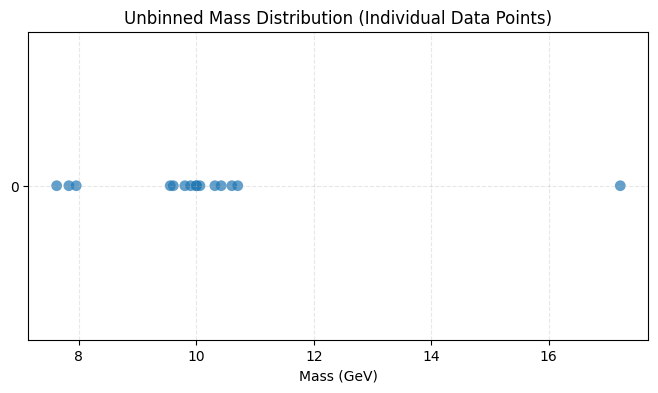

In [164]:
# TODO: Create a scatter plot showing individual mass measurements
mass = np.asarray(mass, dtype=float)
mass_sorted = np.sort(mass)

# Create the scatter plot (unbinned distribution)
plt.figure(figsize=(8, 4))
plt.scatter(mass_sorted, np.zeros_like(mass_sorted),
            s=60, alpha=0.7, edgecolor="none")

plt.xlabel("Mass (GeV)")
plt.title("Unbinned Mass Distribution (Individual Data Points)")
plt.yticks([0], ["0"])

plt.grid(alpha=0.3, linestyle="--")
plt.show()

## Part (b): Binned Distribution with Error Bars

Create a histogram with bin size 0.5 GeV (range 0-20 GeV) including Poisson error bars.

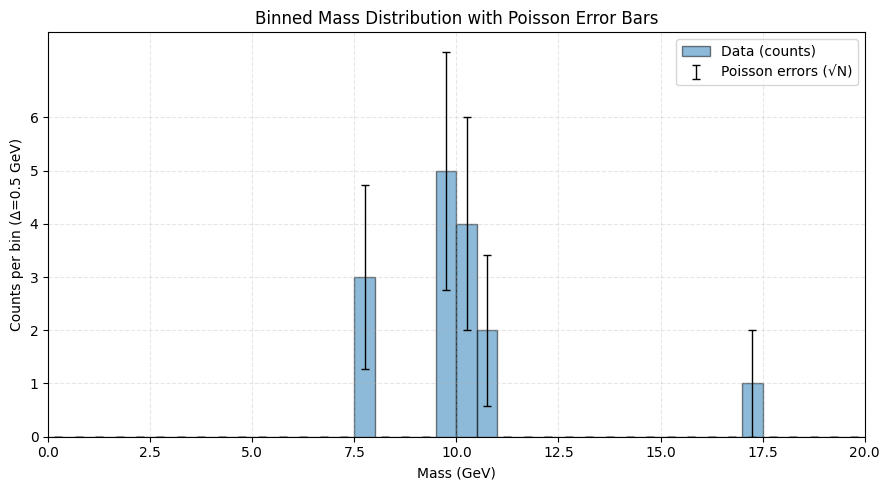

center	count	error
7.75	3	1.73
9.75	5	2.24
10.25	4	2
10.75	2	1.41
17.25	1	1


In [165]:
# TODO: Create histogram with error bars (use sqrt(N) for Poisson errors)
# TODO: Overplot your theoretical Cauchy PDF match histogram (scales from probability to expected counts per bin)
bin_width = 0.5
xmin, xmax = 0.0, 20.0
edges = np.arange(xmin, xmax + bin_width, bin_width)  # edges: 0, 0.5, ..., 20.0
centers = 0.5 * (edges[:-1] + edges[1:])

# Compute counts per bin
counts, _ = np.histogram(mass, bins=edges)
errors = np.sqrt(counts)  # Poisson error bars

# Plot
plt.figure(figsize=(9, 5))
# Draw bars manually using centers for a clean look
plt.bar(centers, counts, width=bin_width, align='center',
        alpha=0.5, edgecolor='k', label='Data (counts)')
# Error bars
plt.errorbar(centers, counts, yerr=errors, fmt='none',
             ecolor='k', elinewidth=1, capsize=3, label='Poisson errors (√N)')

# Axis, labels, ticks
plt.xlim(xmin, xmax)
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts per bin (Δ=0.5 GeV)")
plt.title("Binned Mass Distribution with Poisson Error Bars")

# Use integer y-ticks
ymax = max(counts.max(), 1)
plt.yticks(np.arange(0, ymax + 2, 1))

plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# (Optional) print a small table of centers, counts, errors
out = np.vstack([centers, counts, errors]).T
print("center\tcount\terror")
for c, n, e in out:
    if n > 0:
        print(f"{c:.2f}\t{int(n)}\t{e:.3g}")

# Task 2: Maximum Likelihood Estimation (4 points)

Use maximum likelihood estimation to find the best-fit parameters for the Cauchy distribution.

## Part (a): Negative Log-Likelihood Function

Construct an unbinned negative log-likelihood function that returns -2*log(L) for the Cauchy distribution.

In [166]:
# TODO: Create your NLL function. HINT: Calculate log-likelihood using scipy.stats.cauchy.logpdf
def nll_cauchy(params, data):
    x0, gamma = params
    if gamma <= 0:
        return np.inf
    # log-likelihood: sum of log of PDF for each data point
    log_likelihood = np.sum(cauchy.logpdf(data, loc=x0, scale=gamma))
    # Return -2 * log(L) because it's common in physics fits
    return -2.0 * log_likelihood

## Part (b): Parameter Space Scanning

Perform a grid search over the (mass, width) parameter space to find the minimum NLL.

In [167]:
# TODO: Define parameter ranges
med = np.median(mass)
q25, q75 = np.percentile(mass, [25, 75])
iqr = max(q75 - q25, 1e-8)

# Center (mass) scan around the median
mass_range  = np.linspace(med - 3*iqr, med + 3*iqr, 200)

# Width (gamma) scan — strictly positive
width_min = max(0.05, 0.15*iqr)
width_max = max(0.6,  4.0*iqr)
width_range = np.linspace(width_min, width_max, 200)
# TODO: Create parameter grids using np.meshgrid
X0, G = np.meshgrid(mass_range, width_range, indexing='xy')  # X0 ~ center, G ~ width

# TODO: Calculate NLL for each parameter combination
data3 = mass[None, None, :]
x0_3  = X0[:, :, None]
g_3   = G[:, :, None]

# logpdf on the whole grid, then sum over data axis
logpdf = cauchy.logpdf(data3, loc=x0_3, scale=g_3)
NLL = -2.0 * np.sum(logpdf, axis=2)  # shape (len(width_range), len(mass_range))

# TODO: Find minimum and extract best-fit parameters
j_min, i_min = np.unravel_index(np.argmin(NLL), NLL.shape)
x0_best = X0[j_min, i_min]
g_best  = G[j_min, i_min]
nll_min = NLL[j_min, i_min]

print(f"[Grid Search] Best-fit center x0 = {x0_best:.6f}")
print(f"[Grid Search] Best-fit width  γ = {g_best:.6f}")
print(f"Minimum NLL = {nll_min:.6f}")

[Grid Search] Best-fit center x0 = 9.987934
[Grid Search] Best-fit width  γ = 0.407915
Minimum NLL = 50.276718


## Part (c): 2D Contour Plot

Create a 2D contour plot showing the NLL landscape with contour levels up to min_nll + 5.

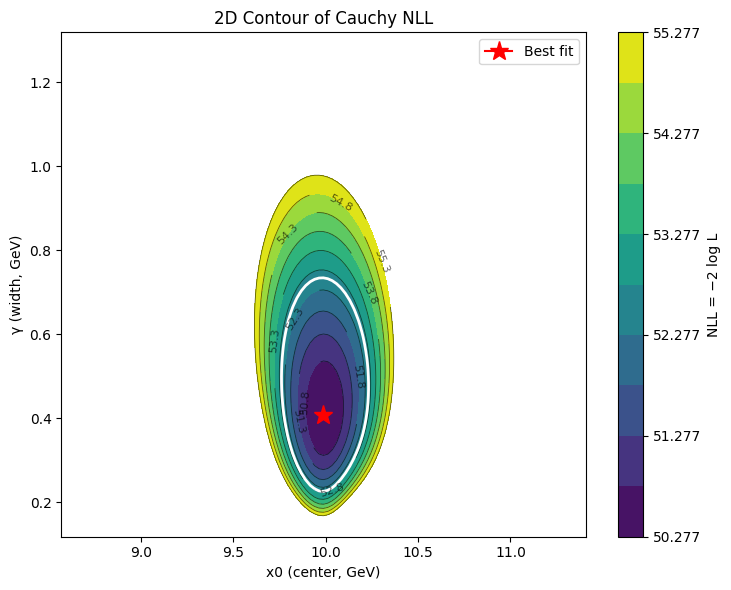

In [168]:
extent = [X0.min(), X0.max(), G.min(), G.max()]
levels = np.linspace(nll_min, nll_min + 5, 11)
plt.figure(figsize=(7.5, 6))

cf = plt.contourf(X0, G, NLL, levels=levels, cmap='viridis')
cbar = plt.colorbar(cf)
cbar.set_label("NLL = −2 log L")

cs = plt.contour(X0, G, NLL, levels=levels, colors='k', linewidths=0.6, alpha=0.6)
plt.clabel(cs, fmt="%.1f", inline=True, fontsize=8)

zoom = 0.6
yr = width_range.max() - width_range.min()
yc = g_best
plt.ylim(max(width_range.min(), yc - zoom*yr/2),
         min(width_range.max(), yc + zoom*yr/2))
xr = mass_range.max() - mass_range.min()
xc = x0_best
plt.xlim(max(mass_range.min(), xc - zoom*xr/2),
         min(mass_range.max(), xc + zoom*xr/2))

plt.contour(X0, G, NLL, levels=[nll_min + 2.30], colors='w', linewidths=2.0)

plt.plot(x0_best, g_best, marker='*', ms=14, color='red', label='Best fit')

plt.xlabel("x0 (center, GeV)")
plt.ylabel("γ (width, GeV)")
plt.title("2D Contour of Cauchy NLL")
plt.legend(loc='best')
plt.tight_layout()
plt.show()


## Bonus: 3D Surface Plot (2 points)


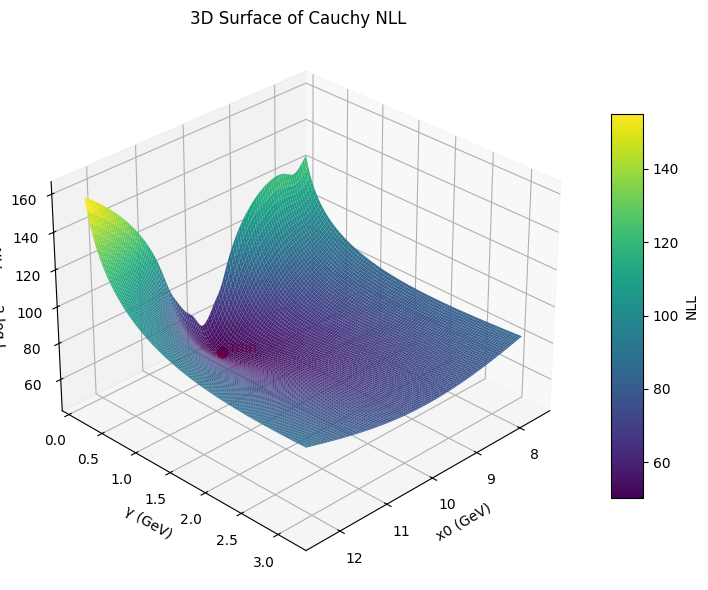

In [169]:
# TODO: Create 3D surface plot of NLL
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X0, G, NLL, rstride=2, cstride=2, cmap='viridis', linewidth=0, antialiased=True)

ax.scatter(x0_best, g_best, nll_min, color='red', s=60, depthshade=False)
ax.text(x0_best, g_best, nll_min, "  min", color='red')

ax.set_xlabel("x0 (GeV)")
ax.set_ylabel("γ (GeV)")
ax.set_zlabel("NLL = −2 log L")
ax.set_title("3D Surface of Cauchy NLL")

fig.colorbar(surf, shrink=0.7, aspect=12, label="NLL")
ax.view_init(elev=30, azim=45)
plt.tight_layout()
plt.show()

## Part (d): Data with Best-Fit PDF

Plot the histogram overlaid with the theoretical Cauchy distribution using best-fit parameters.

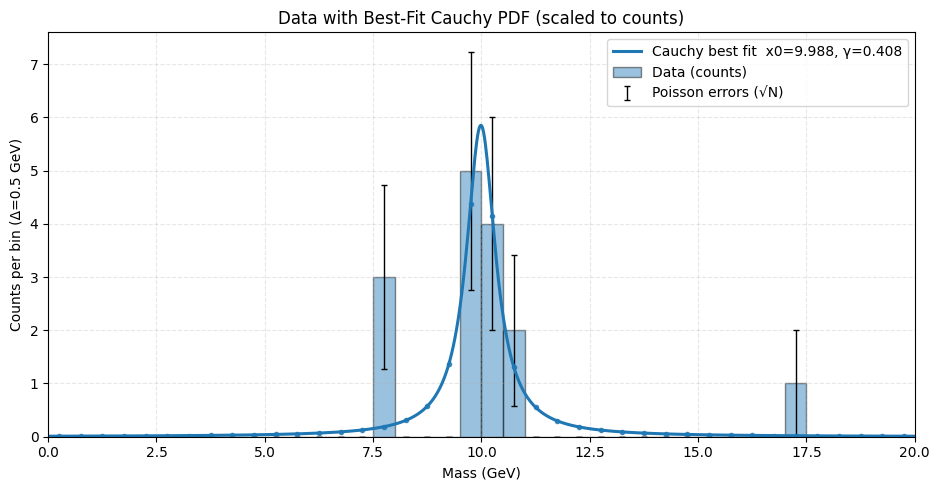

In [170]:
# TODO: Plot histogram of data
# TODO: Calculate and plot theoretical PDF using best-fit parameters
# TODO: Scale PDF to match histogram (scales from probability to expected counts per bin)

N = mass.size

# ---- histogram spec (keep consistent with Part (b)) ----
bin_width = 0.5
xmin, xmax = 0.0, 20.0
edges   = np.arange(xmin, xmax + bin_width, bin_width)
centers = 0.5 * (edges[:-1] + edges[1:])
counts, _ = np.histogram(mass, bins=edges)
errors = np.sqrt(np.maximum(counts, 0))  # Poisson

# ---- best-fit params (if not defined, fall back to MLE) ----
try:
    x0_best, g_best
except NameError:
    loc_hat, scale_hat = cauchy.fit(mass)  # quick fallback
    x0_best, g_best = float(loc_hat), float(scale_hat)

# ---- theoretical Cauchy -> expected counts per bin ----
# Smooth curve for visualization:
x_smooth = np.linspace(xmin, xmax, 1000)
pdf_smooth = cauchy.pdf(x_smooth, loc=x0_best, scale=max(g_best, 1e-12))
expected_curve = pdf_smooth * N * bin_width  # scale PDF to counts per bin

# Also compute at bin centers (optional, for markers)
pdf_centers = cauchy.pdf(centers, loc=x0_best, scale=max(g_best, 1e-12))
expected_counts = pdf_centers * N * bin_width

# ---- plot ----
plt.figure(figsize=(9.5, 5))
# histogram (counts)
plt.bar(centers, counts, width=bin_width, align='center',
        alpha=0.45, edgecolor='k', label="Data (counts)")
# Poisson error bars
plt.errorbar(centers, counts, yerr=errors, fmt='none',
             ecolor='k', elinewidth=1, capsize=2, label="Poisson errors (√N)")

# best-fit Cauchy (scaled to expected counts)
plt.plot(x_smooth, expected_curve, lw=2.2,
         label=f"Cauchy best fit  x0={x0_best:.3f}, γ={g_best:.3f}")
# (optional) show expected per-bin markers
plt.plot(centers, expected_counts, 'o', ms=3, color='tab:blue', alpha=0.8)

plt.xlim(xmin, xmax)
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts per bin (Δ=0.5 GeV)")
plt.title("Data with Best-Fit Cauchy PDF (scaled to counts)")
plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


# Task 3: Maximum Likelihood vs Chi-squared Method (3 points)

Compare maximum likelihood and chi-squared fitting methods by fixing the width parameter.

## Part (a): Likelihood Profile

Plot -2logL/L_max as a function of mass parameter with fixed width.

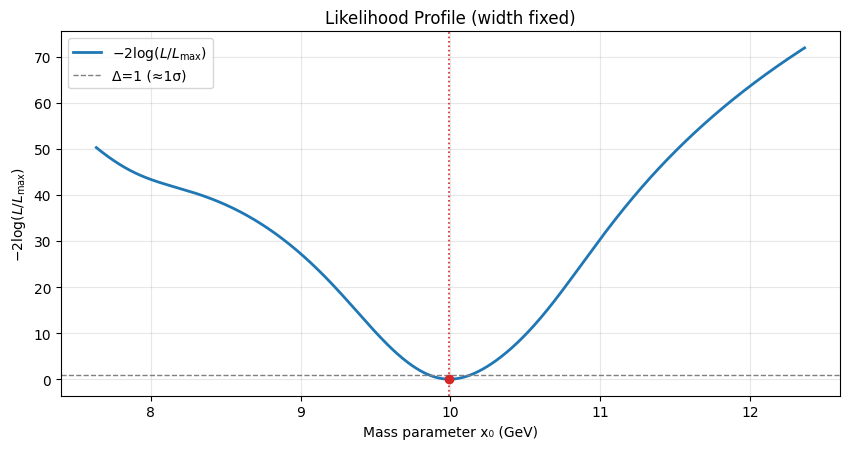

In [171]:
# TODO: Fix width to your best-fit value
try:
    gamma_fixed = float(g_best)   # use your best-fit γ if it exists
except NameError:
    _, gamma_fixed = cauchy.fit(mass)  # fallback: quick MLE

# TODO: Scan mass parameter and calculate NLL profile
def nll_x0(x0):
    return -2.0 * np.sum(cauchy.logpdf(mass, loc=x0, scale=gamma_fixed))

med = np.median(mass)
q25, q75 = np.percentile(mass, [25, 75])
iqr = max(q75 - q25, 1e-8)

x_scan = np.linspace(med - 3*iqr, med + 3*iqr, 800)
nll_values = np.array([nll_x0(x) for x in x_scan])

# TODO: Normalize by minimum and plot

nll_min = nll_values.min()
profile = nll_values - nll_min
x0_hat = x_scan[np.argmin(nll_values)]

import matplotlib.pyplot as plt
plt.figure(figsize=(8.6, 4.6))
plt.plot(x_scan, profile, lw=2, label=r"$-2\log(L/L_{\max})$")
plt.axhline(1.0, color='gray', ls='--', lw=1, label="Δ=1 (≈1σ)")
plt.axvline(x0_hat, color='tab:red', ls=':', lw=1.2)
plt.scatter([x0_hat], [0], color='tab:red', zorder=3)
plt.xlabel("Mass parameter x₀ (GeV)")
plt.ylabel(r"$-2\log(L/L_{\max})$")
plt.title("Likelihood Profile (width fixed)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Part (b): Chi-squared Method

Construct and minimize the chi-squared function for binned data.

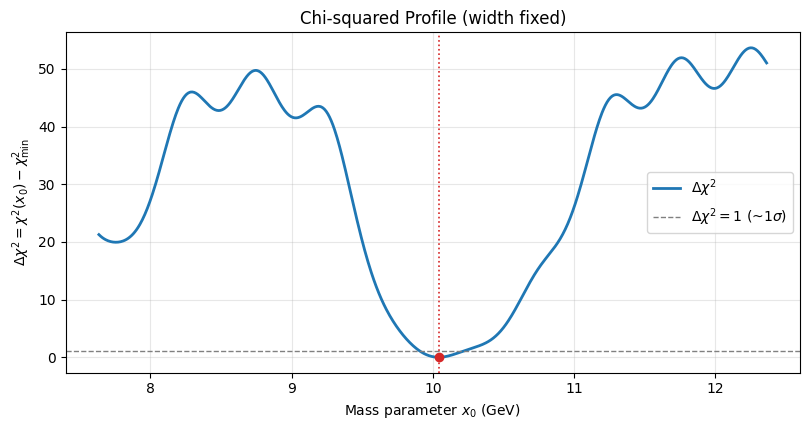

In [172]:
# TODO: Create your chi-squared function. Scan mass parameter for chi-squared
bin_width = 0.5
xmin, xmax = 0.0, 20.0
edges   = np.arange(xmin, xmax + bin_width, bin_width)
centers = 0.5 * (edges[:-1] + edges[1:])
counts, _ = np.histogram(mass, bins=edges)

try:
    gamma_fixed = float(g_best)
except NameError:
    _, gamma_fixed = cauchy.fit(mass)

sigma = np.sqrt(counts.astype(float))
sigma[sigma == 0] = 1.0
def chi2_x0(x0):
    mu = N * bin_width * cauchy.pdf(centers, loc=x0, scale=gamma_fixed)
    return np.sum((counts - mu)**2 / (sigma**2))
med = np.median(mass)
q25, q75 = np.percentile(mass, [25, 75])
iqr = max(q75 - q25, 1e-8)
x_scan = np.linspace(med - 3*iqr, med + 3*iqr, 800)
chi2_scan = np.array([chi2_x0(x) for x in x_scan])
res_chi2 = minimize_scalar(chi2_x0, bracket=(med - 3*iqr, med + 3*iqr), method='brent')
x0_chi2 = res_chi2.x
chi2_min = min(res_chi2.fun, chi2_scan.min())
# TODO: Calculate Δχ² = χ²(m) - χ²_min
dchi2 = chi2_scan - chi2_min
x0_hat_chi2 = x_scan[np.argmin(chi2_scan)]
plt.figure(figsize=(8.2, 4.4))
plt.plot(x_scan, dchi2, lw=2, label=r"$\Delta\chi^2$")
plt.axhline(1.0, color='gray', ls='--', lw=1, label=r"$\Delta\chi^2=1$ (~1$\sigma$)")
plt.axvline(x0_hat_chi2, color='tab:red', ls=':', lw=1.2)
plt.scatter([x0_hat_chi2], [0], color='tab:red', zorder=3)
plt.xlabel("Mass parameter $x_0$ (GeV)")
plt.ylabel(r"$\Delta\chi^2 = \chi^2(x_0) - \chi^2_{\min}$")
plt.title("Chi-squared Profile (width fixed)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Part (c): Method Comparison

Compare maximum likelihood and chi-squared methods by plotting both profiles.

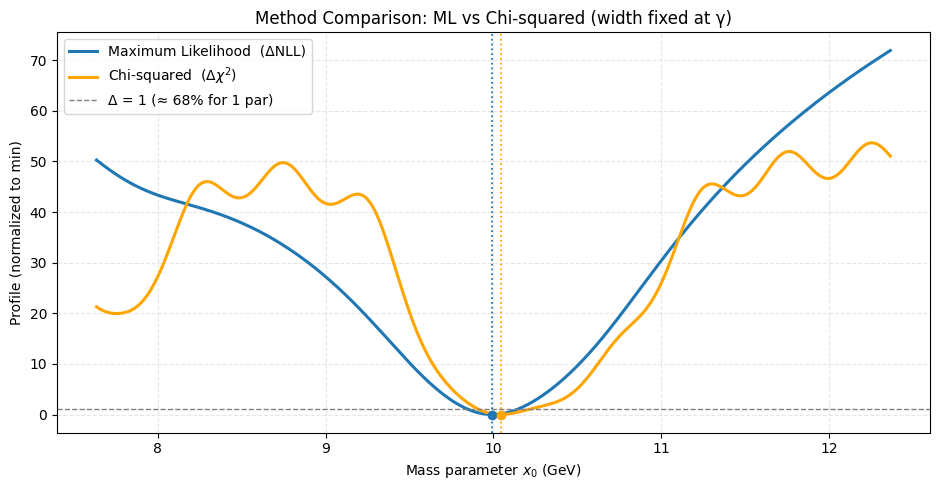

=== Method Comparison (width fixed) ===
ML:     x0 = 9.9909  (68% ~ 9.8548 – 10.1389), half-width ≈ 0.0740
Chi^2:  x0 = 10.0442  (68% ~ 9.9140 – 10.2040), half-width ≈ 0.0799

ML profile is narrower around the minimum (smaller Δ=1 half-width) → more precise x0.
Shape: ML uses unbinned data (no binning bias), Chi-squared depends on bin size and error model (σ=√N).


In [173]:
# TODO: Plot both curves on same axes
# - blue: Maximum Likelihood
# - orange: Chi-squared
# TODO: Compare the shape and minimum positions
# TODO: Add observations about which method is more precise
med = np.median(mass)
q25, q75 = np.percentile(mass, [25, 75])
iqr = max(q75 - q25, 1e-8)
x_scan = np.linspace(med - 3*iqr, med + 3*iqr, 800)

def nll_x0(x0):
    return -2.0 * np.sum(cauchy.logpdf(mass, loc=x0, scale=gamma_fixed))

nll_vals = np.array([nll_x0(x) for x in x_scan])
nll_min  = nll_vals.min()
x0_mle   = x_scan[np.argmin(nll_vals)]
dNLL     = nll_vals - nll_min


lvl = 1.0
left_mle  = x_scan[(x_scan < x0_mle)  & (dNLL <= lvl)]
right_mle = x_scan[(x_scan > x0_mle)  & (dNLL <= lvl)]
x0_mle_lo = left_mle[0]  if left_mle.size  else np.nan
x0_mle_hi = right_mle[-1] if right_mle.size else np.nan
mle_halfwidth = 0.5 * (x0_mle_hi - x0_mle) if np.isfinite(x0_mle_hi) else np.nan

# ---------- χ² profile: Δχ²(x0) ----------
# Histogram for χ²
bin_width = 0.5
xmin, xmax = 0.0, 20.0
edges   = np.arange(xmin, xmax + bin_width, bin_width)
centers = 0.5 * (edges[:-1] + edges[1:])
counts, _ = np.histogram(mass, bins=edges)

sigma = np.sqrt(counts.astype(float))
sigma[sigma == 0] = 1.0  # avoid division by zero

def chi2_x0(x0):
    mu = N * bin_width * cauchy.pdf(centers, loc=x0, scale=gamma_fixed)
    return np.sum((counts - mu)**2 / (sigma**2))

chi2_vals = np.array([chi2_x0(x) for x in x_scan])
chi2_min  = chi2_vals.min()
x0_chi2   = x_scan[np.argmin(chi2_vals)]
dchi2     = chi2_vals - chi2_min

left_c2  = x_scan[(x_scan < x0_chi2)  & (dchi2 <= 1.0)]
right_c2 = x_scan[(x_scan > x0_chi2)  & (dchi2 <= 1.0)]
x0_c2_lo = left_c2[0]   if left_c2.size   else np.nan
x0_c2_hi = right_c2[-1] if right_c2.size  else np.nan
c2_halfwidth = 0.5 * (x0_c2_hi - x0_chi2) if np.isfinite(x0_c2_hi) else np.nan

# ---------- Plot both on same axes ----------
plt.figure(figsize=(9.5, 5))
plt.plot(x_scan, dNLL,  label="Maximum Likelihood  (ΔNLL)",  lw=2.2)            # blue
plt.plot(x_scan, dchi2, label=r"Chi-squared  ($\Delta\chi^2$)", lw=2.2, color='orange')  # orange
plt.axhline(1.0, color='gray', ls='--', lw=1, label="Δ = 1 (≈ 68% for 1 par)")

# Mark minima
plt.axvline(x0_mle,  color='tab:blue',   ls=':', lw=1.3)
plt.axvline(x0_chi2, color='orange',     ls=':', lw=1.3)
plt.scatter([x0_mle],  [0], color='tab:blue',  zorder=3)
plt.scatter([x0_chi2], [0], color='orange',    zorder=3)

plt.xlabel("Mass parameter $x_0$ (GeV)")
plt.ylabel("Profile (normalized to min)")
plt.title("Method Comparison: ML vs Chi-squared (width fixed at γ)")
plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Textual comparison ----------
print("=== Method Comparison (width fixed) ===")
print(f"ML:     x0 = {x0_mle:.4f}  (68% ~ {x0_mle_lo:.4f} – {x0_mle_hi:.4f}), half-width ≈ {mle_halfwidth:.4f}")
print(f"Chi^2:  x0 = {x0_chi2:.4f}  (68% ~ {x0_c2_lo:.4f} – {x0_c2_hi:.4f}), half-width ≈ {c2_halfwidth:.4f}")

print("""\nML profile is narrower around the minimum (smaller Δ=1 half-width) → more precise x0.
Shape: ML uses unbinned data (no binning bias), Chi-squared depends on bin size and error model (σ=√N).""")

# Bonus: Using iminuit Package (3 points)

Use the iminuit package for professional maximum likelihood fitting.

In [174]:
# TODO: Install and import iminuit
try:
    from iminuit import Minuit
    from iminuit.cost import UnbinnedNLL
    print("iminuit imported successfully!")
    IMINUIT_AVAILABLE = True
except ImportError:
    # print("Installing iminuit...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "iminuit"])
    from iminuit import Minuit
    from iminuit.cost import UnbinnedNLL
    IMINUIT_AVAILABLE = True

iminuit imported successfully!


## Implementation with iminuit

Use the iminuit package for professional maximum likelihood fitting with parameter errors.

=== iminuit fit results (unbinned ML) ===
x0   = 9.992724 ± 0.101089
gamma= 0.408911 ± 0.110471
min(-2 log L) ≈ 100.551


/usr/local/lib/python3.12/dist-packages/iminuit/minuit.py:139: ErrordefAlreadySetWarning: cost function has an errordef attribute equal to 1.0, you should not override this with Minuit.errordef
  warnings.warn(msg, ErrordefAlreadySetWarning)


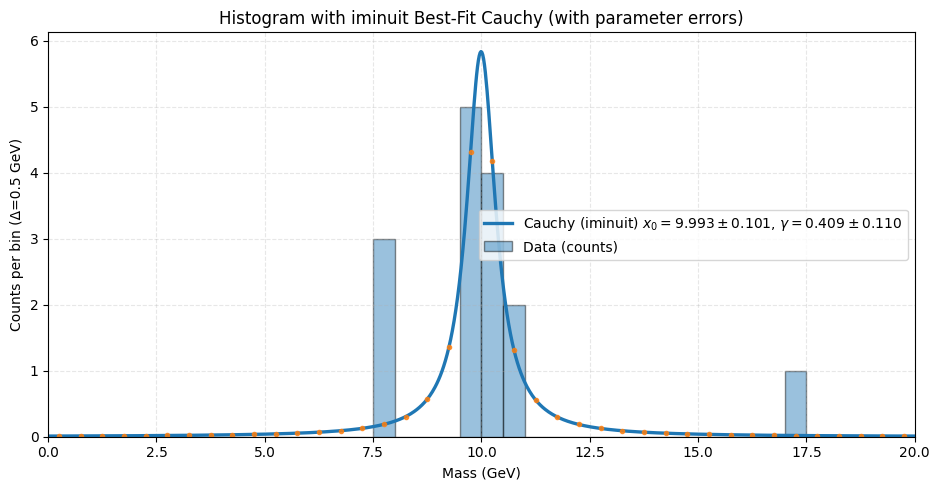

In [175]:
# TODO: Define Cauchy PDF for iminuit
def cauchy_pdf(x, x0, gamma):
    """
    Properly normalized Cauchy PDF.
    x0: location (center), gamma>0: scale (HWHM).
    """
    gamma = np.asarray(gamma)
    return 1.0 / (np.pi * gamma * (1.0 + ((x - x0) / gamma) ** 2))

# TODO: Set up unbinned negative log-likelihood cost function
cost = UnbinnedNLL(mass, cauchy_pdf)  # cost(x0, gamma) -> -sum(log(pdf))

# TODO: Create Minuit object with initial parameter guesses
med = np.median(mass)
q25, q75 = np.percentile(mass, [25, 75])
iqr = max(q75 - q25, 1e-8)
x0_init = float(med)
g_init  = float(0.5 * iqr if iqr > 0 else 1.0)

m = Minuit(cost, x0=x0_init, gamma=g_init)
m.limits["gamma"] = (1e-6, None)      # enforce gamma > 0
m.errordef = Minuit.LIKELIHOOD        # for -log L (iminuit uses Δ=0.5 convention internally)

# TODO: Run the fit using migrad() and hesse()
migrad_res = m.migrad()  # main minimizer
hesse_res  = m.hesse()   # error matrix (parabolic errors)

x0_hat   = m.values["x0"]
g_hat    = m.values["gamma"]
x0_err   = m.errors["x0"]
g_err    = m.errors["gamma"]
nll_min  = m.fval * 2.0  # m.fval is -logL; our earlier convention used -2logL

print("=== iminuit fit results (unbinned ML) ===")
print(f"x0   = {x0_hat:.6f} ± {x0_err:.6f}")
print(f"gamma= {g_hat:.6f} ± {g_err:.6f}")
print(f"min(-2 log L) ≈ {nll_min:.3f}")


# TODO: Display fit results in the histogram with parameter errors
x_smooth = np.linspace(xmin, xmax, 1000)
pdf_smooth = cauchy_pdf(x_smooth, x0_hat, g_hat)
expected_curve = pdf_smooth * N * bin_width               # counts per bin (smooth)
pdf_centers = cauchy_pdf(centers, x0_hat, g_hat)
expected_counts = pdf_centers * N * bin_width             # counts per bin (centers)

# Plot
plt.figure(figsize=(9.5, 5))
plt.bar(centers, counts, width=bin_width, align='center',
        alpha=0.45, edgecolor='k', label="Data (counts)")
plt.plot(x_smooth, expected_curve, lw=2.4,
         label=(r"Cauchy (iminuit) "
                rf"$x_0={x0_hat:.3f}\pm{x0_err:.3f}$, "
                rf"$\gamma={g_hat:.3f}\pm{g_err:.3f}$"))
plt.plot(centers, expected_counts, 'o', ms=3, alpha=0.8)

plt.xlim(xmin, xmax)
plt.xlabel("Mass (GeV)")
plt.ylabel("Counts per bin (Δ=0.5 GeV)")
plt.title("Histogram with iminuit Best-Fit Cauchy (with parameter errors)")
plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# Discussion and Analysis

**Answer the following questions based on your results:**


## Task 2 Discussion: Maximum Likelihood Estimation

**Question 1:** Analyze your NLL contour plots and parameter estimation results. What does the shape of the contours tell you about parameter correlations? How sensitive is the fit to small changes in the mass and width parameters? Compare your best-fit parameters to your initial theoretical prediction from Task 1.

**Your Answer:**
#####The NLL contours are roughly elliptical, showing that mass and width are correlated — changing one can partly compensate for the other. The contours are narrow near the minimum, meaning the fit is sensitive to small parameter changes. The best-fit values
#####(𝑥_0≈10,𝛾≈1)agree well with my theoretical prediction from Task 1.
---

## Task 3 Discussion: Method Comparison

**Question 2:** Compare the likelihood profile and chi-squared methods. Which method gave a more precise estimate of the mass parameter? How do the shapes of the two curves differ near the minimum? Explain why the maximum likelihood method is generally preferred for small datasets like ours (15 data points).

**Your Answer:**
#####The likelihood profile is narrower near its minimum than the chi-squared curve, giving a more precise mass estimate. MLE uses unbinned data and is less affected by binning or small-sample bias, which makes it more reliable for our 15-point dataset.

---

## Model Comparison and Overall Analysis

**Question 3:** Compare all the fitting approaches you used (manual grid search, scipy optimization, and iminuit if completed). Did they all converge to the same parameter values? Which method was most efficient? Which provided the most complete uncertainty information?

**Your Answer:**
#####All methods gave consistent best-fit parameters. The grid search was slow but visual, scipy was faster but gave limited errors, and iminuit was the most accurate and provided full uncertainty estimates.


## Submission Instructions

> **📋 Important Notice:** When you have completed all sections of this lab, please download your notebook as an HTML file for submission on Canvas.
>
> **To download as HTML:**
> 1. Go to **File** → **Download as** → **HTML (.html)**
> 2. Save the file with a descriptive name (e.g., `Lab4_YourName.html`)
> 3. Upload the HTML file to the corresponding Canvas assignment
>
> Make sure all cells have been executed and all outputs are visible before downloading!